# Similarity Measures in Multimodal Retrieval


* This tutorial assumes an Anaconda 3.x installation with Python 3.6.x. Missing libraries can be installed with _conda_ or _pip_.

In [1]:
%matplotlib inline
import os
import tarfile as TAR
import sys
from datetime import datetime
from PIL import Image
import warnings
import json
import pickle
import zipfile
from math import *

import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import matplotlib
# enlarge plots
plt.rcParams['figure.figsize'] = [7, 5]

import imagehash

from sklearn.preprocessing import normalize
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import hamming
from scipy.stats import wasserstein_distance
from scipy.stats import spearmanr

from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches, BRIEF, corner_peaks, corner_harris)
from skimage.color import rgb2gray
from skimage.io import imread,imshow


def printLog(text):
    now = str(datetime.now())
    print("[" + now + "]\t" + text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()
    
def findJPEGfiles(path):
    # a list for the JPEG files
    jpgFilePaths=[]
    for root, dirs, files in os.walk(path):
        for file_ in files:
            if file_.endswith(".jpg"):
                # debug
                # print(os.path.join(root, file_))
                jpgFilePaths.append(os.path.join(root, file_))
    return jpgFilePaths

outputDir= "./analysis/"
verbose=True

#general preparations, e.g., create missing output directories
if not os.path.exists(outputDir):
    if verbose:
        print("Creating " + outputDir)
        os.mkdir(outputDir)

Most likely, the [ImageHash library](https://pypi.org/project/ImageHash/) will be missing in a typical setup. The following cell, installs the library.

In [2]:
!pip install ImageHash

## Feature Extraction

In the next step, we have to find all images that we want to use in our retrieval scenario and extract the needed histogram-based and hash-based features.

In [3]:
#baseDir="/Users/david/src/__datasets/orbis_pictus/sbbget_downloads_comenius/download_temp/"
baseDir="/Users/david/src/__datasets/orbis_pictus/jpegs/download_temp/"

jpgFiles=findJPEGfiles(baseDir)

# extract all features
printLog("Extracting features of %i documents..."%len(jpgFiles))
histograms=[]

# "data science" utility structures
ppnList=[]
nameList=[]
combinedHistograms=[]
combinedNormalizedHistograms=[]
jpegFilePaths=[]
pHashes=[]
    
for jpg in jpgFiles:
    tokens=jpg.split("/")
    # load an image
    image = Image.open(jpg)
    # bug: images are not of the same size, has to be fixed to obtain normalized histograms!!!
    histogram = image.histogram()
    histogramDict=dict()
    # save its unique ID and name
    histogramDict['ppn']=tokens[-3]+"/"+tokens[-2]
    histogramDict['extractName']=tokens[-1]
    # save the histogram data in various forms
    histogramDict['redHistogram'] = histogram[0:256]
    histogramDict['blueHistogram'] = histogram[256:512]
    histogramDict['greenHistogram'] = histogram[512:768]
    hist=np.array(histogram)
    normalizedRGB = (hist)/(max(hist))
    # create a perceptual hash for the image
    pHashes.append(imagehash.phash(image))
    image.close()
    
    # fill the DS data structures
    ppnList.append(histogramDict['ppn'])
    nameList.append(histogramDict['extractName'])
    combinedHistograms.append(histogramDict['redHistogram']+histogramDict['blueHistogram']+histogramDict['greenHistogram'])
    combinedNormalizedHistograms.append(normalizedRGB)
    jpegFilePaths.append(jpg)
printLog("Done.")

[2019-04-28 14:01:24.485032]	Extracting features of 1731 documents...
[2019-04-28 14:02:44.329089]	Done.


To check whether the file search has succeeded, display some found images to get a feeling of the data we are going to deal with.

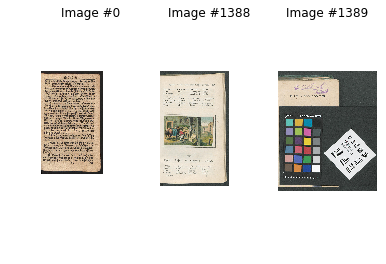

In [4]:
img1=imread(jpegFilePaths[0])
img2=imread(jpegFilePaths[1388])
img3=imread(jpegFilePaths[1389])

#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharex='all', sharey='all')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax1.set_title("Image #0")
ax1.imshow(img1)
ax2.set_title("Image #1388")
ax2.imshow(img2)
ax3.set_title("Image #1389")
ax3.imshow(img3)

## Detecting Similar Documents

To get started, we will inspect the results of two fairly simply approaches, the difference and intersection of two histograms.
### Histogram Difference

The histogram difference is computed between the two first images displayed above. The dashed line illustrates the actual difference between the two images' histograms.

165.28621023553535


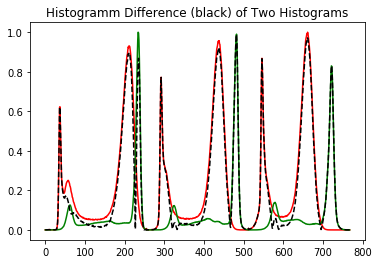

In [5]:
plt.plot(combinedNormalizedHistograms[0],"r")
plt.plot(combinedNormalizedHistograms[1388],"g")

histCut=np.absolute((np.subtract(combinedNormalizedHistograms[0],combinedNormalizedHistograms[1388])))
print(np.sum(histCut))
plt.plot(histCut,"k--")
plt.title("Histogramm Difference (black) of Two Histograms")
plt.show()

### Histogram Intersection

An alternative measure is the histogram intersection which computes the "amount of change" between the two histograms.

25.657086066118932


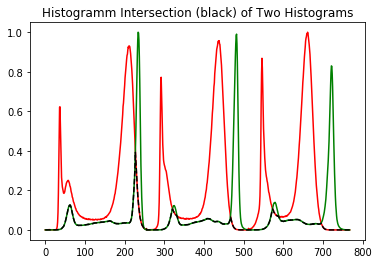

In [6]:
plt.plot(combinedNormalizedHistograms[0],"r")
plt.plot(combinedNormalizedHistograms[1388],"g")

histCut=(np.minimum(combinedNormalizedHistograms[0],combinedNormalizedHistograms[1388]))
print(np.sum(histCut))
plt.plot(histCut,"k--")
plt.title("Histogramm Intersection (black) of Two Histograms")
plt.show()

## Comparison of Different Similarity Measures and Metrics in a QBE Scenario

To compare the effectiveness of different similarity computations, we will use a query by example (QBE) scenario in which we check a query image (#1392) against all other images in the corpus to find the most similar ones. These found images will be displayed in form of a list ordered by relevance.

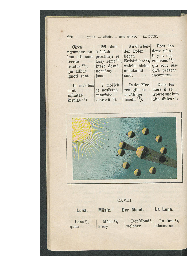

In [7]:
qbeIndex=1392#1685 # beim 1685 sind p1 und p2 am Anfang gleich
img1=imread(jpegFilePaths[qbeIndex])
#plt.title(jpegFilePaths[qbeIndex])
plt.axis('off')
imshow(img1)

The next cell computes different measures and metrics and saves them in a dataframe.

In [8]:
def squareRooted(x):
    return round(sqrt(sum([a*a for a in x])),3)
 
def cosSimilarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = squareRooted(x)*squareRooted(y)
    return round(numerator/float(denominator),3)

printLog("Calculating QBE scenarios...")
qbeHist=combinedNormalizedHistograms[qbeIndex]
dataDict={"index":[],"p1":[],"p2":[],"histdiff":[],"histcut":[],"emd":[],"cosine":[],"phash":[]}
for i,hist in enumerate(combinedNormalizedHistograms):
    dataDict["index"].append(i)
    # Manhattan distance
    dataDict["p1"].append(minkowski(qbeHist,hist,p=1))
    # Euclidean distance
    dataDict["p2"].append(minkowski(qbeHist,hist,p=2))
    
    # histogram difference
    histDiff=np.absolute((np.subtract(qbeHist,combinedNormalizedHistograms[i])))
    dataDict["histdiff"].append(np.sum(histDiff))
    
    # histogram cut
    histCut=np.minimum(qbeHist,combinedNormalizedHistograms[i])
    dataDict["histcut"].append(np.sum(histCut))
    
    # earth mover's distance aka Wasserstein
    dataDict["emd"].append(wasserstein_distance(qbeHist,hist))
    
    # cosine similarity
    dataDict["cosine"].append(cosSimilarity(qbeHist,combinedNormalizedHistograms[i]))
    
    # pHash with Hamming distance
    dataDict["phash"].append(hamming(pHashes[qbeIndex],pHashes[i]))
df=pd.DataFrame(dataDict)
printLog("Done.")

[2019-04-28 14:02:45.831193]	Calculating QBE scenarios...
[2019-04-28 14:02:47.433679]	Done.


If we inspect the dataframe, we will see that each measure/metric yields different results which is not very surprising...

In [9]:
df.sort_values(by=['p1']).head(20).describe()

,index,p1,p2,histdiff,histcut,emd,cosine,phash
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1530.500000,9.969812,0.618316,9.969812,46.174548,0.007852,0.990250,0.950000
std,107.064417,2.477130,0.170159,2.477130,2.468614,0.003110,0.003945,0.223607
min,1378.000000,0.000000,0.000000,0.000000,41.584686,0.000000,0.984000,0.000000
25%,1407.750000,9.838062,0.584324,9.838062,43.992812,0.006267,0.987750,1.000000
50%,1551.000000,10.716440,0.660475,10.716440,46.570927,0.007469,0.990000,1.000000
75%,1620.000000,10.967056,0.702823,10.967056,47.717363,0.010119,0.992250,1.000000
max,1693.000000,11.661428,0.807852,11.661428,51.408998,0.012615,1.000000,1.000000


To facilitate the assessment of the effectiveness of the different measures and metrics, the next cell creates an HTML overview document with the first found documents.

In [10]:
measures=["p1","p2","histdiff","histcut","emd","cosine","phash"]
ranks=dict()
printLog("Creating QBE report files...")

htmlFile=open(outputDir+"_qbe.html", "w")
printLog("HTML output will be saved to: %s"%outputDir+"_qbe.html")
htmlFile.write("<html><head>\n")
htmlFile.write("<link href='../css/helvetica.css' rel='stylesheet' type='text/css'>\n")
#htmlFile.write("<style>body {color: black;text-align: center; font-family: helvetica;} h1 {font-size:15px;position: fixed; padding-top:5px; top: 0;width: 100%;background: rgba(255,255,255,0.5);} h2 {font-size:15px;position: fixed; right: 0;width: 150px; padding-top:25px; padding-right:15px; background: rgba(255,255,255,0.5);} p {font-size:10px;} .score{font-size:6px; text-align: right;}")
htmlFile.write("</style></head>\n")

htmlFile.write("<h2>mir comparison.</h2>")
htmlFile.write("<table><tr>\n")
for measureName in measures:
    typeOfMeasure="distance"
    # check whether the measure is a similarity or a distance measure 
    # (assuming identity (i.e., identity of indiscernibles) of the measure)
    if df[df.index==qbeIndex][measureName].tolist()[0]>0:
        df2=df.sort_values(by=[measureName],ascending=False).head(20)
        typeOfMeasure="similarity"
    else:
        df2=df.sort_values(by=[measureName],ascending=True).head(20)
        typeOfMeasure="distance"

    htmlFile.write("<td>\n")
    measureTitle=measureName
    if typeOfMeasure=="similarity":
        measureTitle=measureName.replace("dist_","sim_")
    htmlFile.write("<h1>"+measureTitle+"</h1>\n")
    htmlFile.write("<p>"+typeOfMeasure+"</p>\n")
    ranks[measureName]=df2.index.tolist()

    jpegFilePathsReport=[]
    # image directory must be relative to the directory of the html files
    imgBaseDir="./extracted_images/"
    for row in df2.itertuples(index=False):
        i=row.index
        score=getattr(row, measureName)
        # create JPEG copies if not available already
        tiffImage=imgBaseDir+ppnList[i]+"/"+nameList[i]
        jpgPath=tiffImage.replace(".tif",".jpg")
        if not os.path.exists(outputDir+jpgPath):
            image = Image.open(outputDir+tiffImage)
            image.thumbnail((512,512))
            image.save(outputDir+jpgPath)
            image.close()
            os.remove(outputDir+tiffImage)
        jpegFilePathsReport.append(outputDir+jpgPath)
        if i==qbeIndex:
            htmlFile.write("<img height=150 src='"+jpgPath+"' alt='"+str(i)+"'/>\n")
        else:
            htmlFile.write("<img height=150 src='"+jpgPath+"' alt='"+str(i)+"'/>\n")
        #htmlFile.write("<p class='score'>"+str(score)+"</p>")   
        htmlFile.write("<p class='score'>&nbsp;</p>\n")
        
    htmlFile.write("</td>\n")
# close the HTML file
htmlFile.write("</tr></table>\n")
htmlFile.write("</body></html>\n")
htmlFile.close()

printLog("Done.")

[2019-04-28 14:02:47.481209]	Creating QBE report files...
[2019-04-28 14:02:47.482090]	HTML output will be saved to: ./analysis/_qbe.html
[2019-04-28 14:02:47.499449]	Done.


## A Local Feature - ORB

The local ORB (Oriented FAST and Rotated BRIEF) [feature](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.ORB) takes interesting regions of an image into account - the so-called keypoints. In cotrast to the presented approaches which only consider the whole image at a time and which are therefore called global features, local feature extractors search for keypoints and try to match them with the ones found in another image. 

Hypothetically speaking, such features should be helpful to discover similar details in different images no matter how they differ in scale or rotation. Hence, ORB is considered relatively scale and rotation invariant.

In this section, we will investigate wheter ORB can be used to find pages in the Orbis Pictus decribing the concept of the "world" which are present in three editions of the book as displayed below.

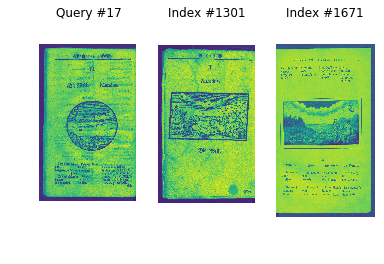

In [11]:
qbeIndexLocalFeat=17#qbeIndex#17 #17=Welt
img1=imread(jpegFilePaths[qbeIndexLocalFeat],as_gray=True)
img2=imread(jpegFilePaths[1301],as_gray=True)
img3=imread(jpegFilePaths[1671],as_gray=True)

#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharex='all', sharey='all')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax1.set_title("Query #%i"%qbeIndexLocalFeat)
ax1.imshow(img1)
ax2.set_title("Index #1301")
ax2.imshow(img2)
ax3.set_title("Index #1671")
ax3.imshow(img3)

To give an example, we will extract ORB features from the first two images and match them. The discovered matches will be illustrated below.

Text(0.5,1,'Image 1 vs. Image 2')

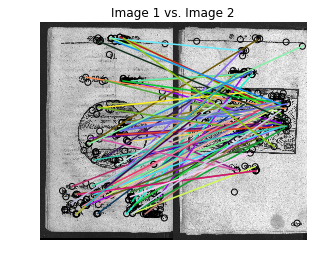

In [12]:
# extract features
descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

# match features
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

# visualize the results
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.gray()

plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Image 1 vs. Image 2")

In [14]:
printLog("Calculating ORB QBE scenarios...")
#qbeIndexLocalFeat
# prepare QBE image
descriptor_extractor = ORB(n_keypoints=200)

# prepare QBE image
qbeImage=imread(jpegFilePaths[qbeIndexLocalFeat],as_gray=True)
descriptor_extractor.detect_and_extract(qbeImage)
qbeKeypoints = descriptor_extractor.keypoints
qbeDescriptors = descriptor_extractor.descriptors

orbDescriptors=[]
orbMatches=[]

# match QBE image against the corpus
dataDict={"index":[],"matches_orb":[]}
for i,jpeg in enumerate(jpegFilePaths):
    dataDict["index"].append(i)
    compImage=imread(jpeg,as_gray=True)
    descriptor_extractor.detect_and_extract(compImage)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    orbDescriptors.append(descriptors)
    matches = match_descriptors(qbeDescriptors, descriptors, cross_check=True)#,max_distance=0.5)
    orbMatches.append(matches)
    # naive approach: count the number of matched descriptors
    dataDict["matches_orb"].append(matches.shape[0])
    
    if i%100==0:
        printLog("Processed %i documents of %i."%(i,len(jpegFilePaths)))
    
df=pd.DataFrame(dataDict)
printLog("Done.")

[2019-04-28 14:08:01.742304]	Calculating QBE scenarios...
[2019-04-28 14:08:08.215664]	Processed 0 documents of 1731.
[2019-04-28 14:13:40.239570]	Processed 100 documents of 1731.
[2019-04-28 14:19:21.580146]	Processed 200 documents of 1731.
[2019-04-28 14:24:36.879682]	Processed 300 documents of 1731.
[2019-04-28 14:29:52.490208]	Processed 400 documents of 1731.
[2019-04-28 14:35:05.079539]	Processed 500 documents of 1731.
[2019-04-28 14:40:16.033386]	Processed 600 documents of 1731.
[2019-04-28 14:45:28.880415]	Processed 700 documents of 1731.
[2019-04-28 14:50:39.968545]	Processed 800 documents of 1731.
[2019-04-28 14:55:52.146773]	Processed 900 documents of 1731.
[2019-04-28 15:01:12.398376]	Processed 1000 documents of 1731.
[2019-04-28 15:06:41.199957]	Processed 1100 documents of 1731.
[2019-04-28 15:12:13.442797]	Processed 1200 documents of 1731.
[2019-04-28 15:17:44.299594]	Processed 1300 documents of 1731.
[2019-04-28 15:23:06.427549]	Processed 1400 documents of 1731.
[2019-04-

In [16]:
df2=df.sort_values(by=['matches_orb'],ascending=False).head(20)
df2.describe()

,index,matches_orb
count,20.000000,20.000000
mean,760.800000,97.050000
std,412.789943,24.310437
min,17.000000,90.000000
25%,483.000000,90.000000
50%,734.000000,91.000000
75%,1092.750000,92.250000
max,1335.000000,200.000000


In [17]:
printLog("Calculating Hamming distances for ORB features and calculating average distance...")
averageDistancePerImage=[]
for i,matches in enumerate(orbMatches):
    # matches qbe
    # matches[:, 0]
    # matches document
    # matches[:, 1]
    qbeMatchIndices=matches[:, 0]
    queryMatchIndices=matches[:, 1]
    sumDistances=0.0
    noMatches=len(qbeMatchIndices)
    for j,qbeMatchIndex in enumerate(qbeMatchIndices):
        sumDistances+=hamming(qbeDescriptors[qbeMatchIndex],orbDescriptors[i][queryMatchIndices[j]])
    avgDistance=sumDistances/noMatches
    averageDistancePerImage.append((avgDistance,i))
    if i%100==0:
        printLog("Processed %i documents of %i."%(i,len(orbMatches)))
        

averageDistancePerImage.sort(key=lambda tup: tup[0])
printLog("Done.\n")

# create the report files
measures=["matches_orb"]
ranks=dict()
printLog("Creating QBE ORB report files...")

htmlFile=open(outputDir+"_orb.html", "w")
printLog("HTML output will be saved to: %s"%outputDir+"_orb.html")

htmlFile.write("<html><head>\n")
htmlFile.write("<link href='../css/helvetica.css' rel='stylesheet' type='text/css'>\n")
#htmlFile.write("<style>body {color: black;text-align: center; font-family: helvetica;} h1 {font-size:15px;position: fixed; padding-top:5px; top: 0;width: 100%;background: rgba(255,255,255,0.5);} h2 {font-size:15px;position: fixed; right: 0;width: 150px; padding-top:25px; padding-right:15px; background: rgba(255,255,255,0.5);} p {font-size:10px;} .score{font-size:6px; text-align: right;}")
htmlFile.write("</style></head>\n")

htmlFile.write("<h2>orb comparison.</h2>")
htmlFile.write("<table><tr>\n")
for measureName in measures:
    typeOfMeasure="similarity"

    htmlFile.write("<td>\n")
    htmlFile.write("<h1>"+measureName+"</h1>\n")
    htmlFile.write("<p>"+typeOfMeasure+"</p>\n")
    ranks[measureName]=df2.index.tolist()

    jpegFilePathsReport=[]
    # image directory must be relative to the directory of the html files
    imgBaseDir="./extracted_images/"
    for row in df2.itertuples(index=False):
        i=row.index
        score=getattr(row, measureName)
        # create JPEG copies if not available already
        tiffImage=imgBaseDir+ppnList[i]+"/"+nameList[i]
        jpgPath=tiffImage.replace(".tif",".jpg")
        if not os.path.exists(outputDir+jpgPath):
            image = Image.open(outputDir+tiffImage)
            image.thumbnail((512,512))
            image.save(outputDir+jpgPath)
            image.close()
            os.remove(outputDir+tiffImage)
        jpegFilePathsReport.append(outputDir+jpgPath)
        if i==qbeIndex:
            htmlFile.write("<img height=150 src='"+jpgPath+"' alt='"+str(i)+"'/>\n")
        else:
            htmlFile.write("<img height=150 src='"+jpgPath+"' alt='"+str(i)+"'/>\n")
        #htmlFile.write("<p class='score'>"+str(score)+"</p>")    
        htmlFile.write("<p class='score'>&nbsp;</p>\n")
    htmlFile.write("</td>\n")

# the non-naive approach using the average distance
htmlFile.write("<td>\n")
htmlFile.write("<h1>dist_avg_orb</h1>\n")
htmlFile.write("<p>"+typeOfMeasure+"</p>\n")

for (dist,index) in averageDistancePerImage[:20]:
    typeOfMeasure="similarity"
    jpegFilePathsReport=[]
    # image directory must be relative to the directory of the html files
    imgBaseDir="./extracted_images/"
    
    i=index
    score=dist
    # create JPEG copies if not available already
    tiffImage=imgBaseDir+ppnList[i]+"/"+nameList[i]
    jpgPath=tiffImage.replace(".tif",".jpg")
    if not os.path.exists(outputDir+jpgPath):
        image = Image.open(outputDir+tiffImage)
        image.thumbnail((512,512))
        image.save(outputDir+jpgPath)
        image.close()
        os.remove(outputDir+tiffImage)
    jpegFilePathsReport.append(outputDir+jpgPath)
    if i==qbeIndex:
        htmlFile.write("<img height=150 src='"+jpgPath+"' alt='"+str(i)+"'/>\n")
    else:
        htmlFile.write("<img height=150 src='"+jpgPath+"' alt='"+str(i)+"'/>\n")
    htmlFile.write("<p class='score'>"+str(score)+"</p>")   
    htmlFile.write("<p class='score'>&nbsp;</p>\n")
        
htmlFile.write("</td>\n")
#eof
# close the HTML file
htmlFile.write("</tr></table>\n")
htmlFile.write("</body></html>\n")
htmlFile.close()

printLog("Done.")


[2019-04-28 18:57:59.737059]	Calculating Hamming distances for ORB features...
[2019-04-28 18:57:59.740678]	Processed 0 documents of 1731.
[2019-04-28 18:57:59.855308]	Processed 100 documents of 1731.
[2019-04-28 18:57:59.969735]	Processed 200 documents of 1731.
[2019-04-28 18:58:00.074637]	Processed 300 documents of 1731.
[2019-04-28 18:58:00.174965]	Processed 400 documents of 1731.
[2019-04-28 18:58:00.275118]	Processed 500 documents of 1731.
[2019-04-28 18:58:00.370154]	Processed 600 documents of 1731.
[2019-04-28 18:58:00.469033]	Processed 700 documents of 1731.
[2019-04-28 18:58:00.579665]	Processed 800 documents of 1731.
[2019-04-28 18:58:00.690340]	Processed 900 documents of 1731.
[2019-04-28 18:58:00.800127]	Processed 1000 documents of 1731.
[2019-04-28 18:58:00.908441]	Processed 1100 documents of 1731.
[2019-04-28 18:58:01.016363]	Processed 1200 documents of 1731.
[2019-04-28 18:58:01.124162]	Processed 1300 documents of 1731.
[2019-04-28 18:58:01.222718]	Processed 1400 documen

## Histogram-based Clustering


[2019-04-28 18:58:03.991398]	Clustering...
[2019-04-28 18:58:04.211864]	Done.
[2019-04-28 18:58:04.212351]	Creating report files...
[2019-04-28 18:58:04.292587]	HTML output will be saved to: ./analysis/_main.html
[2019-04-28 18:58:04.293501]	Done.
[2019-04-28 18:58:04.293940]	Rendering 20 cluster center histograms...


/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=18 should be larger than k=20. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=18 should be larger than k=20. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=18 should be larger than k=20. Setting it to 3*k
  init_size=init_size)


[2019-04-28 18:58:34.459759]	Done.


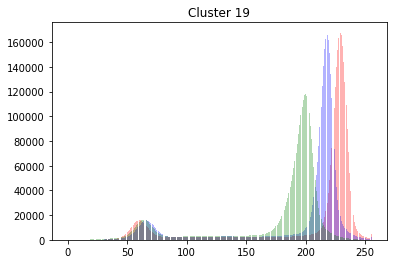

In [18]:
printLog("Clustering...")
X=np.array(combinedHistograms)
numberOfClusters=20
kmeans = MiniBatchKMeans(n_clusters=numberOfClusters, random_state = 0, batch_size = 6)
kmeans=kmeans.fit(X)
printLog("Done.")

printLog("Creating report files...")
htmlFiles=[]
jpegFilePaths=[]
for i in range(0,numberOfClusters):
    htmlFile=open(outputDir+str(i)+".html", "w")
    htmlFile.write("<html><head><link href='../css/helvetica.css' rel='stylesheet' type='text/css'></head>\n<body>\n")
    #htmlFile.write("<h1>Cluster "+str(i)+"</h1>\n")
    htmlFile.write("<img src='"+str(i)+".png' width=200 />") # cluster center histogram will created below
    htmlFiles.append(htmlFile)
# image directory must be relative to the directory of the html files
imgBaseDir="./extracted_images/"
for i, label in enumerate(kmeans.labels_):
    # create JPEG copies if not available already
    tiffImage=imgBaseDir+ppnList[i]+"/"+nameList[i]
    jpgPath=tiffImage.replace(".tif",".jpg")
    if not os.path.exists(outputDir+jpgPath):
        image = Image.open(outputDir+tiffImage)
        image.thumbnail((512,512))
        image.save(outputDir+jpgPath)
        image.close()
        os.remove(outputDir+tiffImage)
    jpegFilePaths.append(outputDir+jpgPath)
    
    htmlFiles[label].write("<img height=200 src='"+jpgPath+"' alt='"+str(len(jpegFilePaths)-1)+"'/>\n")

# close the HTML files
for h in htmlFiles:
    h.write("</body></html>\n")
    h.close()

# create the summarization main HTML page
htmlFile = open(outputDir+"_main.html", "w")
printLog("HTML output will be saved to: %s"%outputDir+"_main.html")

htmlFile.write("<html><head><link href='../css/helvetica.css' rel='stylesheet' type='text/css'></head><body>\n")
htmlFile.write("<h2>cluster results.</h2>\n")
for i in range(0, numberOfClusters):
    htmlFile.write("<iframe src='./"+str(i)+".html"+"' height=400 ><p>Long live Netscape!</p></iframe>")
htmlFile.write("</body></html>\n")
htmlFile.close()
printLog("Done.")

# save the cluster center histograms as images to assist the visualization
printLog("Rendering %i cluster center histograms..."%len(kmeans.cluster_centers_))

for j, histogram in enumerate(kmeans.cluster_centers_):
    plt.figure(0)
    # clean previous plots
    plt.clf()
    plt.title("Cluster %i"%j)
    #red
    for i in range(0, 256):
        plt.bar(i, histogram[i],color='red', alpha=0.3)
    # blue
    for i in range(256, 512):
        plt.bar(i-256, histogram[i], color='blue', alpha=0.3)
    # green
    for i in range(512, 768):
        plt.bar(i-512, histogram[i], color='green', alpha=0.3)
    #debug
    #plt.show()
    plt.savefig(outputDir+str(j)+".png")

printLog("Done.")